Import Packages and define convenience functions for displaying images.

In [1]:
using Images,Distributions
import PyPlot

function imshow(imgs...)
    for i in eachindex(imgs)
        PyPlot.subplot(1,length(imgs),i);
        PyPlot.imshow(imgs[i],"gray")
        PyPlot.axis("off")        
    end
end

function titles(imgs...)
    for i in eachindex(imgs)
        PyPlot.subplot(1,length(imgs),i);
        PyPlot.title(imgs[i])        
    end
end

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


titles (generic function with 1 method)

Load images and ground truth disparity.

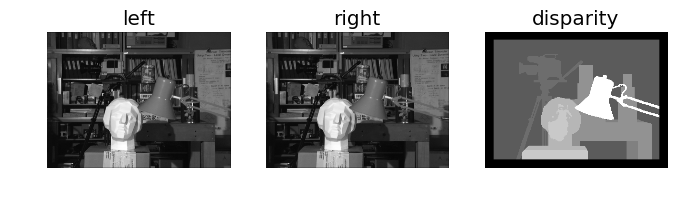

In [2]:
function load_images()
    img0 = 255.*channelview(float64.(Gray.(load("../data/i0.png"))));
    img1 = 255.*channelview(float64.(Gray.(load("../data/i1.png"))));
    
    disparity = 255 * channelview(float64.(load("../data/gt.png")));
    
    return (img0,img1,disparity);
end

i0,i1,d = load_images(); 
imshow(i0,i1,d); titles("left","right","disparity")

Since the ground truth is not defined along the image borders, we simply crop all images using values > 0 in the disparity map.

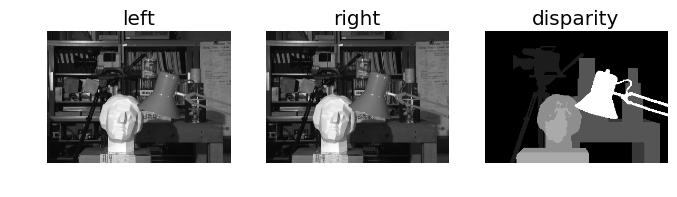

In [6]:
function crop(i0,i1,d)
    @assert size(i0) == size(i1) "Images have different dimensions."
    @assert size(i0) == size(d) "Images have different dimensions."
    
    rows,cols = findn(d);
    r0 = minimum(rows);
    r1 = maximum(rows);
    c0 = minimum(cols);
    c1 = maximum(cols);
    return i0[r0:r1,c0:c1], i1[r0:r1,c0:c1], d[r0:r1,c0:c1]
end

i0c,i1c,dc = crop(i0,i1,d);
imshow(i0c,i1c,dc); titles("left","right","disparity")

Function that shifts each pixel of an image by respective disparity value.

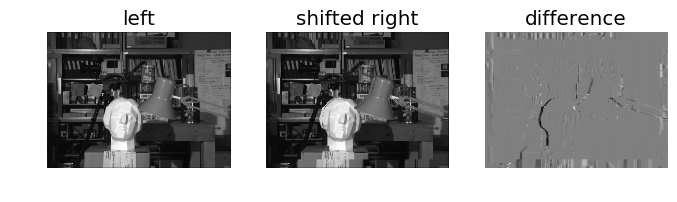

In [5]:
function apply_disparity(right::Array{Float64,2}, disparity::Array{Int64,2})
    
    h,w = size(right);
    left = zeros(h,w);
    
    @assert (h,w) == size(disparity) "Image and disparity map have different dimensions."

    for i in eachindex(right)
        r,c = ind2sub((h,w), i);
        c  -= disparity[i];
        
        if 0 < c && c < w
            left[i] = right[r,c];
        end            
    end

    return left;
end

i1d = apply_disparity(i1,round.(Int,d));
imshow(i0,i1d,i0-i1d); titles("left","shifted right","difference")

Define likelihood and negative log-likelihood for Gaussian.

In [10]:
function compute_gaussian_lh(img0::Array{Float64,2}, img1::Array{Float64,2}, mu::Float64, sigma::Float64)
    @assert size(img0) == size(img1) "Images have different dimensions."
    return prod(pdf.(Normal(mu, sigma), img0-img1));
end

# as in lecture
function compute_gaussian_nllh(img0::Array{Float64,2}, img1::Array{Float64,2}, mu::Float64, sigma::Float64)
    @assert size(img0) == size(img1) "Images have different dimensions."
    N,M = size(img0);
    return sum((img0-img1-mu).^2)/(2*sigma^2) + N*M*log(sqrt(2*pi)*sigma);
end

# using Distributions package
function compute_gaussian_nllh2(img0::Array{Float64,2}, img1::Array{Float64,2}, mu::Float64, sigma::Float64)
    @assert size(img0) == size(img1) "Images have different dimensions."
    return -loglikelihood(Normal(mu, sigma), img0-img1);
end

compute_gaussian_nllh2 (generic function with 1 method)

Add noise to image.

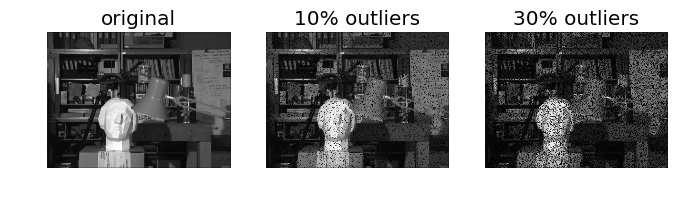

In [11]:
function add_noise(i0,percentage)
    n = length(i0);
    p = round.(Int,percentage*n);
    j0 = copy(i0);
    j0[randperm(n)[1:p]] = rand(p);
    return j0;
end

i1n1 = add_noise(i1,0.1);
i1n3 = add_noise(i1,0.3);
imshow(i1,i1n1,i1n3); titles("original","10% outliers","30% outliers")

Examine how noise affects likelihood and negative log-likelihood.

In [12]:
i1n1d = apply_disparity(i1n1,round.(Int,d));

imgs_orig  = crop(i0,i1d,d);
lh_orig    = compute_gaussian_lh(imgs_orig[1], imgs_orig[2], 0.0, 1.0);
nllh_orig  = compute_gaussian_nllh(imgs_orig[1], imgs_orig[2], 0.0, 1.0);

imgs_noise = crop(i0,i1n1d,d);
lh_noise   = compute_gaussian_lh(imgs_noise[1], imgs_noise[2], 0.0, 1.0);
nllh_noise = compute_gaussian_nllh(imgs_noise[1], imgs_noise[2], 0.0, 1.0);
println(@sprintf " likelihood\t: %.2f (original)\n\t\t  %.2f (with 10%% noise)\n-log-likelihood\t: %.2f (original)\n\t\t  %.2f (with 10%% noise)" lh_orig lh_noise nllh_orig nllh_noise)
println(@sprintf "The likelihood rises by a factor of %.1f" nllh_noise/nllh_orig)

 likelihood	: 0.00 (original)
		  0.00 (with 10% noise)
-log-likelihood	: 8416926.23 (original)
		  42464948.51 (with 10% noise)
The likelihood rises by a factor of 5.0


Define likelihood and negative log-likelihood for Laplacian.

In [13]:
function compute_laplacian_nllh(img0::Array{Float64,2}, img1::Array{Float64,2}, mu::Float64, beta::Float64)
    @assert size(img0) == size(img1) "Images have different dimensions."
    N,M = size(img0);
    return sum(abs(img0-img1-mu))/beta + N*M*log(2*beta);
end

function compute_laplacian_nllh2(img0::Array{Float64,2}, img1::Array{Float64,2}, mu::Float64, beta::Float64)
    @assert size(img0) == size(img1) "Images have different dimensions."
    return -loglikelihood(Laplace(mu, beta), img0-img1);
end

nllh_orig  = compute_laplacian_nllh2(imgs_orig[1],imgs_orig[2], 0.0, 1.0);
nllh_noise = compute_laplacian_nllh2(imgs_noise[1],imgs_noise[2], 0.0, 1.0);
println(@sprintf "-log-likelihood of Laplacian:\t%.2f (original)\n\t\t\t\t%.2f (with 10%% noise)" nllh_orig nllh_noise)
println(@sprintf "The likelihood rises by a factor of %.1f" nllh_noise/nllh_orig)

-log-likelihood of Laplacian:	438888.24 (original)
				1018541.55 (with 10% noise)
The likelihood rises by a factor of 2.3
